In [48]:
import pandas as pd
import numpy as np
import json

from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [49]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

In [50]:
start_idx = 0
end_idx = 5

def compute_sequence_proportions(data_list, start_idx, stop_idx):
    """ 
    New function that takes in the data list and produces proportions of the occurence of the sequence
        start_idx: 0-indexed (if referring to first index, use 0)
        stop_idx: if stopping at second index, use 2
    """
    sequence_counter = Counter()
    total_sequences = 0

    # First pass: Count the occurrences of each sequence
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence in sequence_data.keys():
                    sequence = sequence[start_idx:stop_idx]
                    sequence_counter[sequence] += 1
                    total_sequences += 1

    # Compute the proportion for each sequence
    sequence_proportions = {seq: count / total_sequences for seq, count in sequence_counter.items()}
    return sequence_proportions

sequence_proportions_1 = compute_sequence_proportions(data_list, start_idx, end_idx)
sequence_proportions_2 = compute_sequence_proportions(data_list, start_idx+1, end_idx+1)
sequence_proportions_3 = compute_sequence_proportions(data_list, start_idx+2, end_idx+2)

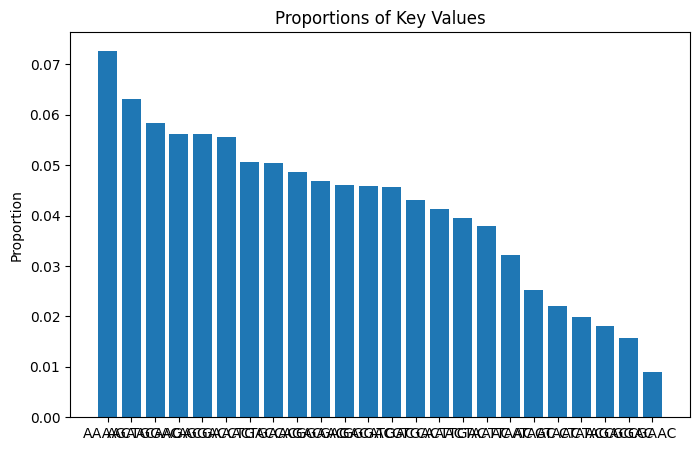

In [51]:
sorted_data = dict(sorted(sequence_proportions_1.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(8, 5))
plt.bar(sorted_data.keys(), sorted_data.values())
plt.ylabel('Proportion')
plt.title('Proportions of Key Values')
plt.show()

In [52]:
# aggregating data_list
def create_aggregated_dataframe(data_list, sequence_proportions_1, sequence_proportions_2, sequence_proportions_3):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)
                    
                    # Calculate the mean, variance, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    var_scores = np.var(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)
                    skew_scores = skew(scores_array, axis=0)
                    kurtosis_scores = kurtosis(scores_array, axis=0)
                    sequence_1 = sequence[start_idx:end_idx]
                    sequence_2 = sequence[start_idx+1:end_idx+1]
                    sequence_3 = sequence[start_idx+2:end_idx+2]
                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position,
                        # 'proportion_1': sequence_proportions_1[sequence_1],
                        # 'proportion_2': sequence_proportions_2[sequence_2],
                        # 'proportion_3': sequence_proportions_3[sequence_3],
                    }
                    
                    for idx in range(scores_array.shape[1]): 
                        transcript_position.update({
                            f'mean_{idx}': mean_scores[idx],
                            f'var_{idx}': var_scores[idx],
                            f'max_{idx}': max_scores[idx],
                            f'min_{idx}': min_scores[idx],
                            f'skewness_{idx}': skew_scores[idx],
                            f'kurtosis_{idx}': kurtosis_scores[idx]
                        })
                    rows.append(transcript_position)
        
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df


# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list, sequence_proportions_1, sequence_proportions_2, sequence_proportions_3)

In [53]:
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [54]:
df_full = pd.merge(aggregated_df, df_labels[['gene_id','transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')
print(df_full.columns)
df = df_full.drop([
    'transcript_id',
    'transcript_position',
], axis = 1)

Index(['transcript_id', 'transcript_position', 'mean_0', 'var_0', 'max_0',
       'min_0', 'skewness_0', 'kurtosis_0', 'mean_1', 'var_1', 'max_1',
       'min_1', 'skewness_1', 'kurtosis_1', 'mean_2', 'var_2', 'max_2',
       'min_2', 'skewness_2', 'kurtosis_2', 'mean_3', 'var_3', 'max_3',
       'min_3', 'skewness_3', 'kurtosis_3', 'mean_4', 'var_4', 'max_4',
       'min_4', 'skewness_4', 'kurtosis_4', 'mean_5', 'var_5', 'max_5',
       'min_5', 'skewness_5', 'kurtosis_5', 'mean_6', 'var_6', 'max_6',
       'min_6', 'skewness_6', 'kurtosis_6', 'mean_7', 'var_7', 'max_7',
       'min_7', 'skewness_7', 'kurtosis_7', 'mean_8', 'var_8', 'max_8',
       'min_8', 'skewness_8', 'kurtosis_8', 'gene_id', 'label'],
      dtype='object')


#### Cluster Data Feature Integration

In [55]:
cluster_data = pd.read_pickle("clustered_dat_scaled.pkl")
pd.set_option('display.max_columns', None)
cluster_data['position'] = cluster_data['position'].astype(int)
merged_df = pd.merge(df_full, cluster_data, left_on=['transcript_id', 'transcript_position'], right_on=['transcript_id', 'position'], how='left')
df_full = merged_df.copy()
df = merged_df.drop(['transcript_id', 'transcript_position', 'position', 'rna_sequence'], axis=1)

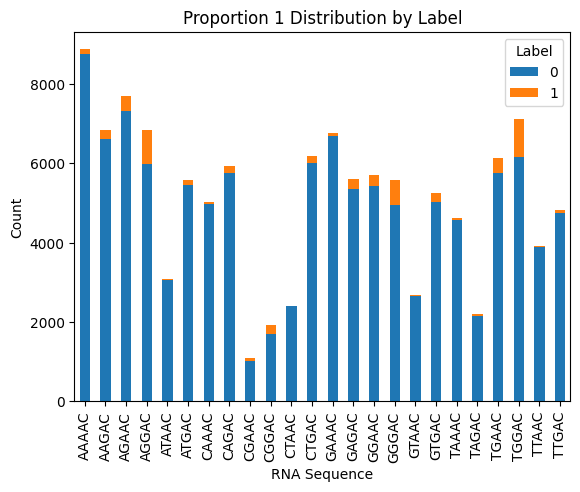

In [56]:
"""Data exploration, I think this overfits to the data we have like Andre mentioned, this is similar to one hot encoding the sequence,
    I was just hoping that perhaps sequences with high occurence leads to low or higher chance of a modification 
"""
def plot_proportion_distribution(proportion_column, label_column, title):
    grouped = merged_df.groupby([proportion_column, label_column]).size().unstack(fill_value=0)
    grouped.plot(kind='bar', stacked=True)
    plt.title(title)
    plt.xlabel('Proportion')
    plt.ylabel('Count')
    plt.legend(title='Label')
    plt.show()

def seq_distribution(proportion_column, label_column, title, pos):
    indexes = {0: [0,5], 1: [1,6], 2: [2,7], 3: [0,7]}
    start, end = indexes[pos]
    merged_df['rna_sequence_slice'] = merged_df[proportion_column].str[start:end]

    grouped = merged_df.groupby(['rna_sequence_slice', label_column]).size().unstack(fill_value=0)

    grouped.plot(kind='bar', stacked=True)
    plt.title(title)
    plt.xlabel('RNA Sequence')
    plt.ylabel('Count')
    plt.legend(title='Label')
    plt.show()

#seq_distribution('rna_sequence', 'label', 'Proportion 1 Distribution by Label', 3)
seq_distribution('rna_sequence', 'label', 'Proportion 1 Distribution by Label', 0)
#seq_distribution('rna_sequence', 'label', 'Proportion 1 Distribution by Label', 1)
#seq_distribution('rna_sequence', 'label', 'Proportion 1 Distribution by Label', 2)
#plot_proportion_distribution('proportion_1', 'label', 'Proportion 1 Distribution by Label')
#plot_proportion_distribution('proportion_2', 'label', 'Proportion 2 Distribution by Label')
#plot_proportion_distribution('proportion_3', 'label', 'Proportion 3 Distribution by Label')

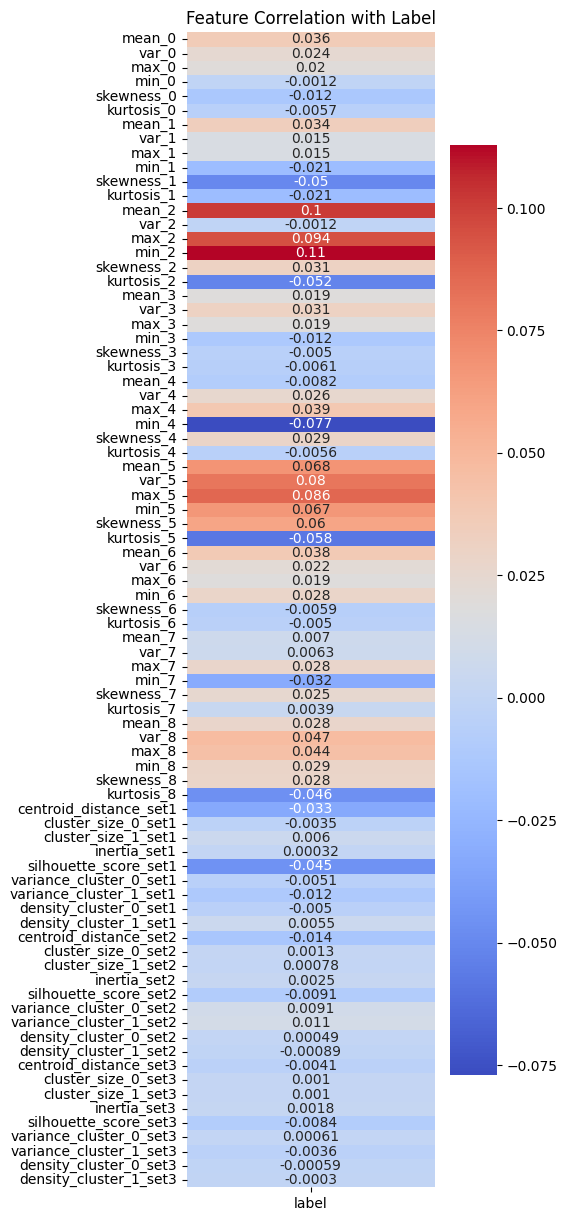

In [57]:
# Cleaning up cluster data's integration
correlation_df = df.drop(['gene_id'], axis=1)
correlation_matrix = correlation_df.corr()
label_correlations = correlation_matrix['label'].drop('label')

plt.figure(figsize=(4, 15))
sns.heatmap(label_correlations.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Feature Correlation with Label')
plt.show()

In [58]:
print(df_full.columns)

Index(['transcript_id', 'transcript_position', 'mean_0', 'var_0', 'max_0',
       'min_0', 'skewness_0', 'kurtosis_0', 'mean_1', 'var_1', 'max_1',
       'min_1', 'skewness_1', 'kurtosis_1', 'mean_2', 'var_2', 'max_2',
       'min_2', 'skewness_2', 'kurtosis_2', 'mean_3', 'var_3', 'max_3',
       'min_3', 'skewness_3', 'kurtosis_3', 'mean_4', 'var_4', 'max_4',
       'min_4', 'skewness_4', 'kurtosis_4', 'mean_5', 'var_5', 'max_5',
       'min_5', 'skewness_5', 'kurtosis_5', 'mean_6', 'var_6', 'max_6',
       'min_6', 'skewness_6', 'kurtosis_6', 'mean_7', 'var_7', 'max_7',
       'min_7', 'skewness_7', 'kurtosis_7', 'mean_8', 'var_8', 'max_8',
       'min_8', 'skewness_8', 'kurtosis_8', 'gene_id', 'label', 'position',
       'rna_sequence', 'centroid_distance_set1', 'cluster_size_0_set1',
       'cluster_size_1_set1', 'inertia_set1', 'silhouette_score_set1',
       'variance_cluster_0_set1', 'variance_cluster_1_set1',
       'density_cluster_0_set1', 'density_cluster_1_set1',
       'ce

In [59]:
y = df_full[['label', 'transcript_id', 'transcript_position']]
x = df_full.drop(['label'], axis=1)

# Extra features to drop if merged with clustering features
x = df_full.drop(['label', 'position', 'rna_sequence'], axis=1)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
X_test = X_test.drop(['transcript_id', 'transcript_position', 'gene_id'], axis=1)
y_test = y_test['label']

In [61]:
df_train = pd.merge(X_train, y_train[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

In [62]:
def sample_with_ratio(group):
    # Separate the group into label 1 and label 0
    label_1 = group[group['label'] == 1]
    label_0 = group[group['label'] == 0]
    
    # For label_1 data
    if len(label_0) == 0:
        # No label_0 data in group
        # Limit label_1 data to at most 5
        sample_label_1 = label_1.sample(n=min(len(label_1), 5), random_state=42)
        sample_label_0 = pd.DataFrame()  # No label_0 data
    else:
        # Calculate the maximum allowed label_1 instances (5:1 ratio)
        max_label_1 = 5 * len(label_0)
        
        if len(label_1) <= max_label_1:
            # Take all label_1 data
            sample_label_1 = label_1
        else:
            # Sample label_1 data to have len(label_1) = 5 * len(label_0)
            sample_label_1 = label_1.sample(n=max_label_1, random_state=42)
        
        # Limit label_0 data to at most 2 rows per group
        sample_label_0 = label_0.sample(n=min(len(label_0), 2), random_state=42)
    
    # Combine the two samples
    combined_sample = pd.concat([sample_label_1, sample_label_0])
    
    # Limit the total rows to 10 if necessary
    if len(combined_sample) > 10:
        combined_sample = combined_sample.sample(n=10, random_state=42)
    
    # Get the remaining data not included in the sample
    sampled_indices = combined_sample.index
    remaining_data = group.drop(sampled_indices)
    
    return combined_sample, remaining_data

sampled_list = []
remaining_list = []

# Group the DataFrame and apply the function
for name, group in df_train.groupby('gene_id'):
    sampled, remaining = sample_with_ratio(group)
    sampled_list.append(sampled)
    remaining_list.append(remaining)

# Combine the lists into DataFrames
df_full = pd.concat(sampled_list).reset_index(drop=True)
df_blind_test = pd.concat(remaining_list).reset_index(drop=True)

In [63]:
df_full = df_full.drop(['gene_id'], axis=1)
# df_blind_test = df_blind_test.drop(['gene_id'], axis=1) # Extra from what was removed from the undersampling of 0s (A lot of 0s with some 1s)

x = df_full.drop(columns=['label'], axis=1)
x = x.drop(['transcript_id', 'transcript_position'], axis=1)
y_train = df_full['label']

# x_blind = df_blind_test.drop(columns=['label'], axis=1)
# x_blind = x_blind.drop(['transcript_id', 'transcript_position'], axis=1)
# y_blind = df_blind_test['label']

In [64]:
smote = SMOTE(random_state=42)
x_smote, y_smote = smote.fit_resample(x, y_train)

# Comment this out to not use SMOTE
x, y_train = x_smote, y_smote

In [65]:
# run this if not using scaled features
X_train_scaled = x
X_test_scaled = X_test

In [66]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x)
X_test_scaled = scaler.transform(X_test)

#### Random Forest

In [67]:
### RANDOM FOREST
print("Random Forest")
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set - Base")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Random Forest
Test Data Set - Base
Accuracy: 0.8937130663164806
ROC AUC: 0.8890265371813566
PR AUC: 0.34813731522211616
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     46561
           1       0.25      0.68      0.37      2175

    accuracy                           0.89     48736
   macro avg       0.62      0.79      0.65     48736
weighted avg       0.95      0.89      0.92     48736



In [68]:
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)

#Takes about 4 minutes for me (yucai) to run this

# Parameters grid
param_grid = {
    'n_estimators': [500, 700, 900], # Default = 100
    'max_depth': [None, 3], # Default = None
    'min_samples_split': [2, 3], # Default = 2
    'min_samples_leaf': [1, 2] # Default = 1
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 900}


In [69]:
# Best model
best_rf = grid_search.best_estimator_
model = RandomForestClassifier(**grid_search.best_params_)
model.fit(X_train_scaled, y_train)

# Predictions, swap out model to best_rf if submitting
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set - Param Searched Best RF Model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Test Data Set - Param Searched Best RF Model
Accuracy: 0.8958880499015102
ROC AUC: 0.892414963240658
PR AUC: 0.35966252037443797
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     46561
           1       0.25      0.69      0.37      2175

    accuracy                           0.90     48736
   macro avg       0.62      0.80      0.66     48736
weighted avg       0.95      0.90      0.92     48736



#### XGBoost

In [70]:
### XBOOST
print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("XGBoost - Base model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

XGBoost


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:25:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost - Base model
Accuracy: 0.8941029218647406
ROC AUC: 0.8971290115771993
PR AUC: 0.374421843816624
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     46561
           1       0.26      0.72      0.38      2175

    accuracy                           0.89     48736
   macro avg       0.62      0.81      0.66     48736
weighted avg       0.95      0.89      0.92     48736



In [71]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Takes ~2 minutes to run

# Define the parameter grid
param_grid = {
    'n_estimators': [ 500, 800], # Default = 100
    'max_depth': [3, 6, 9], # Default = 6
    'learning_rate': [0.01, 0.1, 0.2], 
    'subsample': [0.6, 0.8, 1.0], # Default = 1
    'colsample_bytree': [0.6, 0.8, 1.0], # Default = 1
    'gamma': [0, 0.1, 0.2] # Default = 0
}

xgb_clf = xgb.XGBClassifier(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best parameters found: ", random_search.best_params_)


Best parameters found:  {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


In [72]:
best_params = random_search.best_params_

print("XGBoost")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set - Param Searched Best XGB Model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

XGBoost


c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:27:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Test Data Set - Param Searched Best XGB Model
Accuracy: 0.9066603742613263
ROC AUC: 0.9076278924174862
PR AUC: 0.3976332467494256
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     46561
           1       0.28      0.71      0.40      2175

    accuracy                           0.91     48736
   macro avg       0.63      0.81      0.68     48736
weighted avg       0.95      0.91      0.93     48736



#### Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(class_weight='balanced')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_test, y_pred)

# Output the results
print("Test Data Set - Base DT Model")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

Test Data Set - Base DT Model
Accuracy: 0.7993680236375574
ROC AUC: 0.7203382338383438
PR AUC: 0.3914705279557661
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     46561
           1       0.13      0.63      0.22      2175

    accuracy                           0.80     48736
   macro avg       0.56      0.72      0.55     48736
weighted avg       0.94      0.80      0.86     48736

